In [1]:
import numpy as np
import scipy as sp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Bayes Theorem

$p(\gamma) = 0.1, ~~~~~~~~~~ p(b) = 0.9, ~~~~~~~~~~ p(td|\gamma) = 0.95, ~~~~~~~~~~ p(td|b) = 0.1$

$p(\gamma|td) = \dfrac{p(td|\gamma) p(\gamma)}{p(td)} = \dfrac{p(td|\gamma) p(\gamma)}{p(td|\gamma)p(\gamma) + p(td|b)p(b)} = \dfrac{0.95 \cdot 0.1}{0.95 \cdot 0.1 + 0.1 \cdot 0.9} = \dfrac{19}{37} \approx 0.51$

# Trees and Random Forests

$\textbf{a)}$

Calculate optimal splits: For the provided (data1d.npy, labels1d.npy) one-dimensional binary classi- fication problem, consider all splits where the smallest $i = 1, . . . , N − 1$ data points are grouped into one node and the remaining $N − i$ points into the other. For each of these splits, compute the Gini impurity, entropy and misclassifcation rate, and visualize the split that each of these methods would choose.

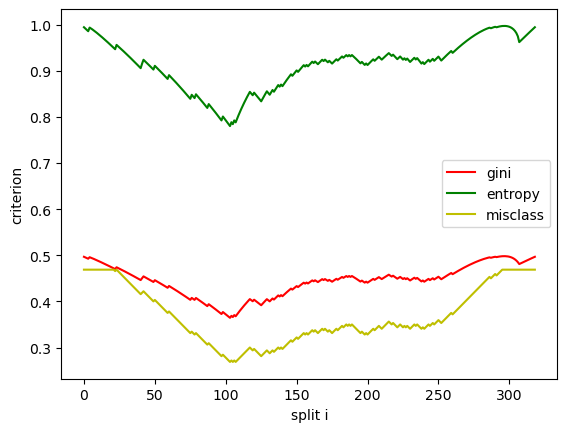

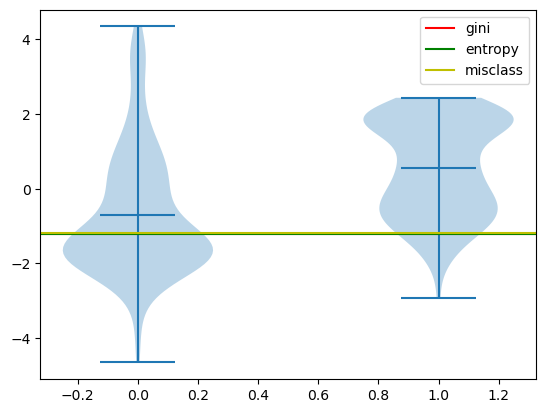

In [2]:
# load the data
pts = np.load('data1d.npy')
labels = np.load('labels1d.npy')


# TODO: Sort the points to easily split them
pts_sorted = pts[np.argsort(pts)]
labels_sorted = labels[np.argsort(pts)]


# TODO: Implement or find implementation for Gini impurity, entropy and misclassifcation rate
def gini_impurity(labels):
    p = np.unique(labels, return_counts=True)[1] / len(labels)
    return 1 - np.sum(p**2)

def entropy(labels):
    p = np.unique(labels, return_counts=True)[1] / len(labels)
    return -np.sum(p * np.log2(p))

def misclassification_rate(labels):
    p = np.unique(labels, return_counts=True)[1] / len(labels)
    return 1 - np.max(p)


# TODO: Iterate over the possible splits, evaulating and saving the three criteria for each one
gini = []
entropys = []
misclass = []
for i in range(1, len(pts_sorted)):
    gini.append((i/len(pts_sorted))*gini_impurity(labels_sorted[:i]) + ((len(pts_sorted)-i)/len(pts_sorted))*gini_impurity(labels_sorted[i:]))
    entropys.append((i/len(pts_sorted))*entropy(labels_sorted[:i]) + ((len(pts_sorted)-i)/len(pts_sorted))*entropy(labels_sorted[i:]))
    misclass.append((i/len(pts_sorted))*misclassification_rate(labels_sorted[:i]) + ((len(pts_sorted)-i)/len(pts_sorted))*misclassification_rate(labels_sorted[i:]))

plt.plot(gini, label='gini', color='r')
plt.plot(entropys, label='entropy', color='g')
plt.plot(misclass, label='misclass', color='y')
plt.xlabel('split i')
plt.ylabel('criterion')
plt.legend()
plt.show()


# TODO: Compute the split that each criterion favours and visualize them 
#       (e.g. with a histogram for each class and vertical lines to show the splits)
gini_split = np.argmin(gini)
entropy_split = np.argmin(entropys)
misclass_split = np.argmin(misclass)

plt.violinplot([pts[labels==0], pts[labels==1]], positions=[0,1], showmeans=True)
plt.axhline(pts_sorted[gini_split], color='r', label='gini')
plt.axhline(pts_sorted[entropy_split], color='g', label='entropy')
plt.axhline(pts_sorted[misclass_split], color='y', label='misclass')
plt.legend()
plt.show()

$\textbf{b)}$

In [3]:
# load the dijet data
features = np.load('dijet_features_normalized.npy')
labels = np.load('dijet_labels.npy')


# TODO: define train, val and test splits as specified (make sure to shuffle the data before splitting it!)
x = np.random.permutation(len(labels))

test_features = features.T[x[0:200]].T
test_labels = labels.T[x[0:200]].T

val_features = features.T[x[200:400]].T
val_labels = labels.T[x[200:400]].T

train_features = features.T[x[400:]].T
train_labels = labels.T[x[400:]].T

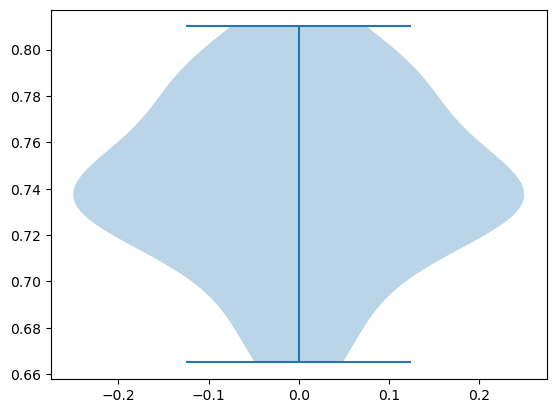

Max score with:
n_estimators: 100, criterion: gini, max_depth: 10, score: 0.81


In [4]:
from sklearn.ensemble import RandomForestClassifier

# TODO: train a random forest classifier for each combination of hyperparameters as specified on the sheet
#       and evaluate the performances on the validation set.

n = [5, 10, 20, 100]
criteria = ['gini', 'entropy']
max_depth = [2, 5, 10, None]

scores = []
max_score = 0
max_params = []

for i in n:
    for j in criteria:
        for k in max_depth:
            rfc = RandomForestClassifier(n_estimators=i, criterion=j, max_depth=k)
            rfc.fit(train_features.T, train_labels)
            score = rfc.score(val_features.T, val_labels)
            scores.append(score)
            if score > max_score:
                max_score = score
                max_params = [i, j, k]

plt.violinplot(scores, positions=[0])
plt.show()

print("Max score with:")
print('n_estimators: ' + str(max_params[0]) + ', criterion: ' + str(max_params[1]) + 
      ', max_depth: ' + str(max_params[2]) + ', score: ' + str(max_score))

In [5]:
# TODO: for your preferred configuration, evaluate the performance of the best configuration on the test set

rfc_max = RandomForestClassifier(n_estimators=max_params[0], criterion=max_params[1], max_depth=max_params[2])
rfc_max.fit(train_features.T, train_labels)
score = rfc_max.score(test_features.T, test_labels)
print('Test score: ' + str(score))

Test score: 0.76


# Fits

$\textbf{a)}$

$- \text{log}(p(\text{data}|\theta)) = - \text{log}\left( \dfrac{1}{\sqrt{2\pi\sigma^2}} \right) - \text{log}( \text{exp} (- \dfrac{1}{2\sigma^2} \sum_{i=1}^{N}(p_i - p(V_{m,i}, \theta))^2))$

$~~~~~~~~~~~~~~~= \text{log}(\sqrt{2\pi\sigma^2}) + \dfrac{1}{2\sigma^2} \sum_{i=1}^{N} (p_i - p(V_{m,i}, \theta))^2$

Here we recognize the negative log-likelihood of a gaussian where the sum equals the MSE.

$\textbf{b)}$

Now we assume that $p(V_{m,i},\theta)$ follows the ideal gas law $p(V_{m,i},R) = \dfrac{R T}{V_{m,i}}$, with our model parameter $\theta = R$. For minimization we can drop some parts of the above negative log-likelihood, since they do not influence the result. Thus we have to minimize the following term for $R$:

$\sum_{i=1}^N (p_i - \dfrac{R T}{V_{m,i}})^2$

The temperature is given as $T = 293K$.

In [6]:
# load the data
p_i, V_i = np.load('gas.npy')

In [7]:
# define the negative log likelihood function using the given data
# ignoring all terms which do not contribute to the minimization
def neg_log_lik(R):
    '''
    Calculates the negative log likelihood.
    The summand log(sqrt(2 pi sig^2)) and the factor 1/2sig^2 can both be neglected, 
    because they do not affeRct the minimization.
    '''
    T = 293
    V = V_i
    p = p_i
       
    return np.sum(np.square(p_i - R*T/V_i))

In [8]:
# minimizing the negative log likelihood for the parameter theta = R
R_est = minimize(neg_log_lik, 1).get('x')[0]
print(f'Minimizing the negative log-likelihood we obtain the following value: R = {R_est} J/K/mol')
# calculating the relative deviation from the scipy value
rel_dev = np.abs(R_est-sp.constants.R)/sp.constants.R
print(f'So the estimator for R has a relative deviation from the scipy-value rel_dev = {rel_dev}')

Minimizing the negative log-likelihood we obtain the following value: R = 8.497071451900045 J/K/mol
So the estimator for R has a relative deviation from the scipy-value rel_dev = 0.02196279450516909


$\textbf{c)}$

Now we assume that $p$ follows the Van-der-Waals-equation $p(V_{i,m},a,b) = \dfrac{RT}{V_{i,m} - b} - \dfrac{a}{V_{m,i}^2}$, where we use our previous obtained estimator for $R$. Therefore, also our negative log-likelihood changes and we have to minimize the following expression for $a$ and $b$:

$\sum_{i=1}^N (p_i - (\dfrac{RT}{V_{i,m} - b} - \dfrac{a}{V_{m,i}^2}))^2$

In [9]:
# define the negative log likelihood function using the given data
# ignoring all terms which do not contribute to the minimization
def neg_log_lik_updated(params):
    '''
    Calculates the negative log likelihood.
    The input params is an array containing the two variables a and b
    '''
    #print(params)
    
    T = 293
    V = V_i
    p = p_i
    R = R_est
    a,b = params
    
    p_est = R*T/(V_i-b) - a/np.square(V_i)
    sqr_dif = np.square(p - p_est)
       
    return np.sum(sqr_dif)

In [10]:
# minimizing the negative log likelihood for the parameters theta = a, b
initial_guess = np.array([0.2476,0.0266])
result = minimize(neg_log_lik_updated, initial_guess)
if result.success:
    fitted_params = result.x
    print(fitted_params)
else: 
    raise ValueError(result.message)

a,b = minimize(neg_log_lik_updated, initial_guess).get('x')
print('Minimizing the negative log-likelihood we obtain the following values:')
print(f'a = {a}')
print(f'b = {b}')

[0.2476 0.0266]
Minimizing the negative log-likelihood we obtain the following values:
a = 0.2476
b = 0.0266
